In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import os
from funzioni import compute_dataset_weighted
from funzioni import compute_annual_mean_weighted
from funzioni import convert_dataset_celsius
from funzioni import compute_anomaly
from funzioni import create_djf_dataset
from funzioni import compute_mean_time_season
from funzioni import compute_mean_resample_mar
from funzioni import plot_bias_atmos
from funzioni import plot_bias_tos
from funzioni import plot_mean_cluster_atmos
from funzioni import plot_mean_cluster_tos
from funzioni import plot_bias_2_models_atmos
from funzioni import plot_bias_2_models_tos
from funzioni import plot_std_cluster_atmos
from funzioni import plot_zonmean
from funzioni import plot_zonmean_2_cluster
from funzioni import plot_mean_cluster_zonmean
from funzioni import plot_std_cluster_tos
from funzioni import plot_std_cluster_zonmean
from funzioni import bs_sample_mean
from funzioni import bs_compute_array_mean_std_95cl
from funzioni import plot_bs_95cl_mean_std
from funzioni import bs_compute_matrix10
from funzioni import plot_bs_mean_cluster_matrix10
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import pylab as pl
import plotly.express as px
import dill
import pickle
import cartopy.crs as ccrs
import random

Caricamento dei file pickle

In [2]:
# Caricamento del dizionario
with open('models.pkl', 'rb') as file:
    models = dill.load(file)
    esa_na_seas_mean_tos = dill.load(file)
    dataset_ESA_na_celsius = dill.load(file)

#Caricamento dei file pickle di modelli_tos
with open('modelli_tos.pickle', 'rb') as f:
    # Caricamento delle 5 liste contenenti i nomi dei modelli all'interno dei 5 cluster
    list_cluster0 = pickle.load(f)
    list_cluster1 = pickle.load(f)
    list_cluster2 = pickle.load(f)
    list_cluster3 = pickle.load(f)
    
    # Caricamento dei 5 cluster in formato pdf
    cluster_0_pdf = pickle.load(f)
    cluster_1_pdf = pickle.load(f)
    cluster_2_pdf = pickle.load(f)
    cluster_3_pdf = pickle.load(f)
    
    # Caricamento dei cluster medi in formato pdf
    cluster_0_mean_pdf = pickle.load(f)
    cluster_1_mean_pdf = pickle.load(f)
    cluster_2_mean_pdf = pickle.load(f)
    cluster_3_mean_pdf = pickle.load(f)

In [3]:
# Salvataggio in un file Pickle
with open('bootstrap_tos.pickle', 'rb') as f: #'rb' = read binary
    array_2th_cluster0_tos = pickle.load(f) #cluster0
    array_97th_cluster0_tos = pickle.load(f) #cluster0
    array_mean_cluster0_tos = pickle.load(f) #cluster0
    array_std_cluster0_tos = pickle.load(f) #cluster0
    matrix10_cluster0_tos = pickle.load(f) #cluster0
    
    array_2th_cluster1_tos = pickle.load(f) #cluster1
    array_97th_cluster1_tos = pickle.load(f) #cluster1
    array_mean_cluster1_tos = pickle.load(f) #cluster1
    array_std_cluster1_tos = pickle.load(f) #cluster1
    matrix10_cluster1_tos = pickle.load(f) #cluster1

    array_2th_cluster2_tos = pickle.load(f) #cluster2
    array_97th_cluster2_tos = pickle.load(f) #cluster2
    array_mean_cluster2_tos = pickle.load(f) #cluster2
    array_std_cluster2_tos = pickle.load(f) #cluster2
    matrix10_cluster2_tos = pickle.load(f) #cluster2

    array_2th_cluster3_tos = pickle.load(f) #cluster3
    array_97th_cluster3_tos = pickle.load(f) #cluster3
    array_mean_cluster3_tos = pickle.load(f) #cluster3
    array_std_cluster3_tos = pickle.load(f) #cluster3
    matrix10_cluster3_tos = pickle.load(f) #cluster3

Valore medio del cluster - array_mean (multi model mean)

In [4]:
#Seasonal mean
for name in models:
    #Seleziono il box Nord Atlantico
    na_box = models[name]['North Atlantic box']
    na_box = na_box.assign_coords(lon=(np.where(na_box.lon >= 280, na_box.lon - 360, na_box.lon))) #metto i valori negativi di lon per mean_bias
    #media temporale delle stagioni MAM, JJA, SON
    for i in range(4): # ciclo su tutte le stagioni
        #Calcolo la media temporale per ogni stagione dei modelli
        model_na_seas_mean = compute_mean_resample_mar(na_box["tos"],"1982","2014",i)
        if (i+1) == 4 : #DJF
            models[name]['tos seasonal mean DJF'] = model_na_seas_mean

In [5]:
#Funzione che calcola la media di un dataset xarray
def compute_mean_tos(name_list,name_dict):
    sum_bias = 0
    #calcolo il valor medio
    for i in range(len(name_list)):
        model_name = name_list[i]
        sum_bias = sum_bias + name_dict[model_name]['tos seasonal mean DJF']
    #valor medio
    mean_cluster0 = sum_bias / len(name_list)
    return mean_cluster0

In [6]:
#plot di diff, cioè la differenza tra il cluster medio e la media della distribuzione bootstrap --> in più ci metto anche i punti di significatività
def plot_bs_diff_cluster_tos(diff,title_plot,v_min,v_max,fig_size,matrix10): #name_models_to_plot indica la lista in cui sono racchiusi i nomi dei modelli da plottare, name_dict è o models_atmos
    fig, ax = plt.subplots(figsize=fig_size,subplot_kw={"projection": ccrs.PlateCarree()}) #trasformazione cartografica = lonxlat   
    plot_mod = ax.pcolormesh(diff.lon, diff.lat, diff,vmin=v_min, vmax=v_max,cmap='seismic') 
    coords = np.where(matrix10 == 1) #array di valori di longitudini e latitudini in cui matrix10 = 1
    # Plot dei punti solo dove matrix10 è uguale a 1
    ax.plot(diff.lon[coords[1]], diff.lat[coords[0]], marker='o', color='black', markersize=2, linestyle='None', transform=ccrs.PlateCarree())
    #imposto lat-lon sugli assi
    #valori assi            
    ax.set_xticks(np.arange(diff.lon.min(),diff.lon.max(), 20))
    ax.set_yticks(np.arange(diff.lat.min(),diff.lat.max(), 10))
    ax.coastlines() #gca = get current axis
    ax.set_ylabel('latitude')
    ax.set_xlabel('longitude')
    # Titolo
    fig.colorbar(plot_mod)
    fig.suptitle(title_plot, fontsize=16, y=1.02)

In [7]:
#Calcolo la multi model mean
#Creo una lista con il nome di tutti i modelli
list_all_models = []
for name in models.keys():
    list_all_models.append(name)
#Multi model mean
multi_model_mean = compute_mean_tos(list_all_models,models)

Cluster 0

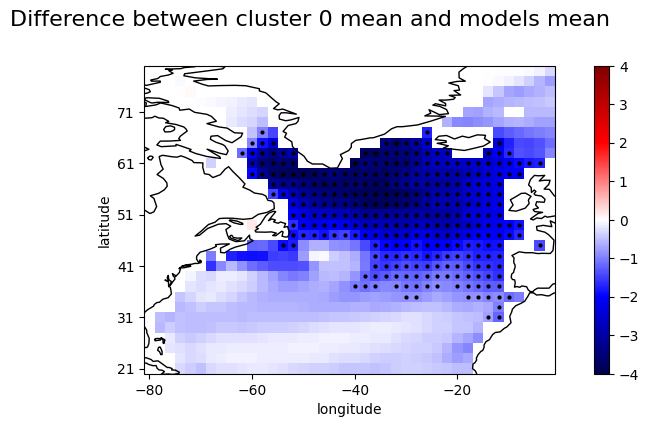

In [8]:
mean_cluster0 = compute_mean_tos(list_cluster0,models)
diff_cluster0 = mean_cluster0 - array_mean_cluster0_tos
plot_bs_diff_cluster_tos(diff_cluster0,'Difference between cluster 0 mean and models mean',-4,4,(10,4),matrix10_cluster0_tos)

Cluster 1

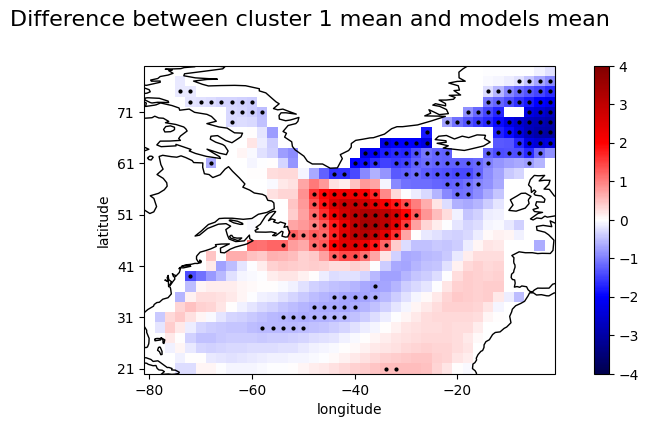

In [9]:
mean_cluster1 = compute_mean_tos(list_cluster1,models)
diff_cluster1 = mean_cluster1 - array_mean_cluster1_tos
plot_bs_diff_cluster_tos(diff_cluster1,'Difference between cluster 1 mean and models mean',-4,4,(10,4),matrix10_cluster1_tos)

Cluster 2

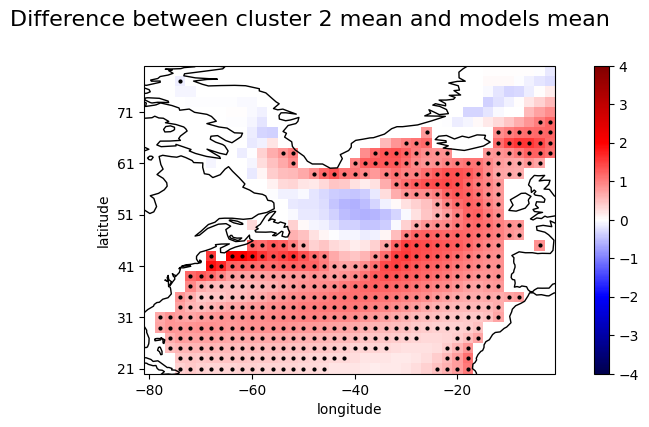

In [10]:
mean_cluster2 = compute_mean_tos(list_cluster2,models)
diff_cluster2 = mean_cluster2 - array_mean_cluster2_tos
plot_bs_diff_cluster_tos(diff_cluster2,'Difference between cluster 2 mean and models mean',-4,4,(10,4),matrix10_cluster2_tos)

Cluster 3

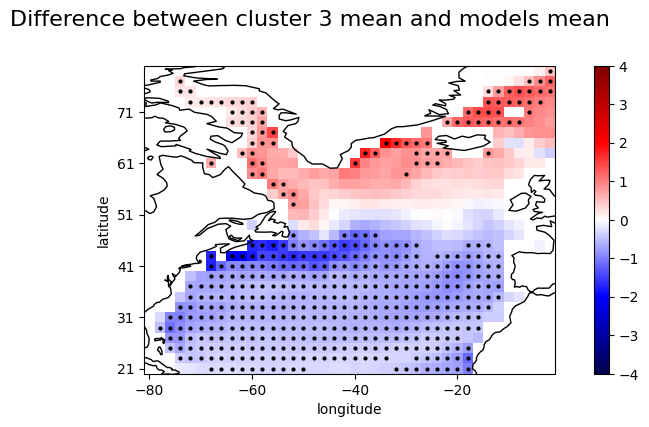

In [11]:
mean_cluster3= compute_mean_tos(list_cluster3,models)
diff_cluster3 = mean_cluster3 - array_mean_cluster3_tos
plot_bs_diff_cluster_tos(diff_cluster3,'Difference between cluster 3 mean and models mean',-4,4,(10,4),matrix10_cluster3_tos)

Plot di media cluster - multi model mean 

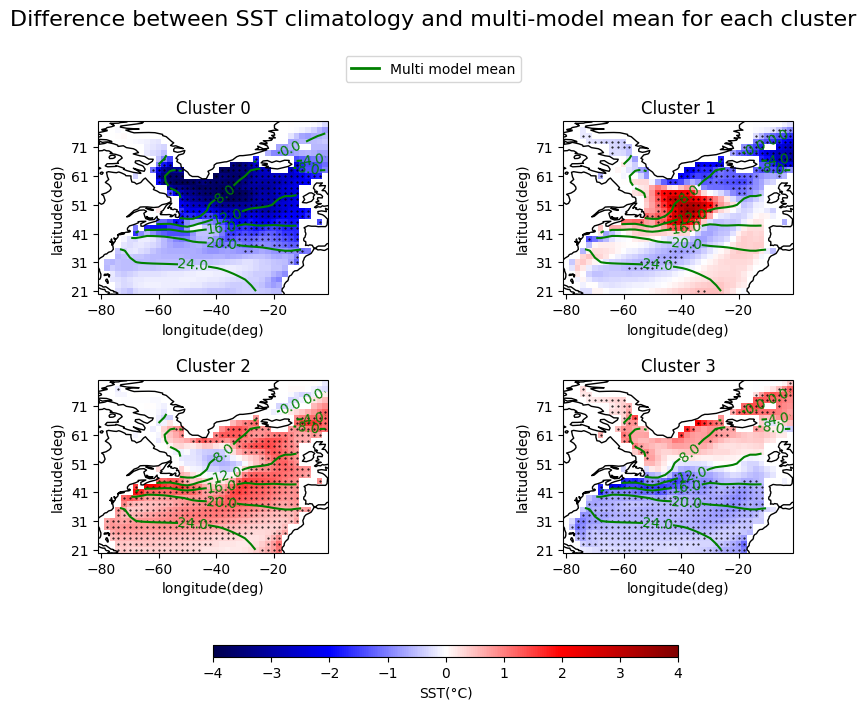

In [14]:
v_min = -4
v_max = 4
k = 0 #indice per cluster
lon=diff_cluster0.lon
lat=diff_cluster0.lat
#plot di diff, cioè la differenza tra il cluster medio e la media della distribuzione bootstrap --> in più ci metto anche i punti di significatività
fig, ax = plt.subplots(nrows=2,ncols=2,figsize=(10,8),subplot_kw={"projection": ccrs.PlateCarree()}) #trasformazione cartografica = lonxlat   
fig.subplots_adjust(hspace=0.5, wspace=0.5)
#ax[0,0]
plot_mod = ax[0,0].pcolormesh(diff_cluster0.lon, diff_cluster0.lat, diff_cluster0,vmin=v_min, vmax=v_max,cmap='seismic') 
coords = np.where(matrix10_cluster0_tos == 1) #array di valori di longitudini e latitudini in cui matrix10 = 1
# Plot dei punti solo dove matrix10 è uguale a 1
ax[0,0].plot(diff_cluster0.lon[coords[1]], diff_cluster0.lat[coords[0]], marker='o', color='black', markersize=0.5, linestyle='None', transform=ccrs.PlateCarree())
contour_models = ax[0,0].contour(lon,lat, array_mean_cluster0_tos, colors='g') #lon,lat
ax[0,0].clabel(contour_models, fmt='%1.1f')
#contour_cluster = ax[0,0].contour(lon,lat, mean_cluster0, colors='black') #lon,lat
#ax[0,0].clabel(contour_cluster, fmt='%1.1f')

#ax[0,1]
ax[0,1].pcolormesh(diff_cluster1.lon, diff_cluster1.lat, diff_cluster1,vmin=v_min, vmax=v_max,cmap='seismic') 
coords = np.where(matrix10_cluster1_tos == 1)
ax[0,1].plot(diff_cluster1.lon[coords[1]], diff_cluster1.lat[coords[0]], marker='o', color='black', markersize=0.5, linestyle='None', transform=ccrs.PlateCarree())
contour_models = ax[0,1].contour(lon,lat, array_mean_cluster1_tos, colors='g') #lon,lat
ax[0,1].clabel(contour_models, fmt='%1.1f')
#contour_cluster = ax[0,1].contour(lon,lat, mean_cluster1, colors='black') #lon,lat
#ax[0,1].clabel(contour_cluster, fmt='%1.1f')

#ax[0,2]
ax[1,0].pcolormesh(diff_cluster2.lon, diff_cluster2.lat, diff_cluster2,vmin=v_min, vmax=v_max,cmap='seismic') 
coords = np.where(matrix10_cluster2_tos == 1)
ax[1,0].plot(diff_cluster2.lon[coords[1]], diff_cluster2.lat[coords[0]], marker='o', color='black', markersize=0.5, linestyle='None', transform=ccrs.PlateCarree())
contour_models = ax[1,0].contour(lon,lat, array_mean_cluster2_tos, colors='g') #lon,lat
ax[1,0].clabel(contour_models, fmt='%1.1f')
#contour_cluster = ax[0,2].contour(lon,lat, mean_cluster2, colors='black') #lon,lat
#ax[0,2].clabel(contour_cluster, fmt='%1.1f')

#ax[1,0]
ax[1,1].pcolormesh(diff_cluster3.lon, diff_cluster3.lat, diff_cluster3,vmin=v_min, vmax=v_max,cmap='seismic') 
coords = np.where(matrix10_cluster3_tos == 1)
ax[1,1].plot(diff_cluster3.lon[coords[1]], diff_cluster3.lat[coords[0]], marker='o', color='black', markersize=0.5, linestyle='None', transform=ccrs.PlateCarree())
contour_models = ax[1,1].contour(lon,lat, array_mean_cluster3_tos, colors='g') #lon,lat
ax[1,1].clabel(contour_models, fmt='%1.1f')
#contour_cluster = ax[1,0].contour(lon,lat, mean_cluster3, colors='black') #lon,lat
#ax[1,0].clabel(contour_cluster, fmt='%1.1f')

#Imposto valori su assi e titolo
for i in range(2):
    for j in range(2):        
        ax[i,j].set_xticks(np.arange(diff_cluster0.lon.min(),diff_cluster0.lon.max(), 20))
        ax[i,j].set_yticks(np.arange(diff_cluster0.lat.min(),diff_cluster0.lat.max(), 10))
        ax[i,j].coastlines() #gca = get current axis
        ax[i,j].set_ylabel('latitude(deg)')
        ax[i,j].set_xlabel('longitude(deg)')
        ax[i,j].set_title(f'Cluster {k}')
        k = k + 1 #aggiorno indice per cluster

# Creazione di un oggetto Line2D per la legenda
green_line = Line2D([0], [0], color='green', lw=2, label='Multi model mean')  
#black_line = Line2D([0], [0], color='black', lw=2, label='Cluster mean')    
# Aggiungo la legenda al plot
#fig.legend(handles=[green_line,black_line],loc='upper center', bbox_to_anchor=(0.5, 0.97), ncol=1)
fig.legend(handles=[green_line],loc='upper center', bbox_to_anchor=(0.5, 0.97), ncol=1)
    # Titolo
fig.colorbar(plot_mod,ax=ax, orientation='horizontal', shrink=0.6, aspect=40).set_label('SST(°C)')
fig.suptitle('Difference between SST climatology and multi-model mean for each cluster', fontsize=16, y=1.02)
fig.savefig('bootstrap_tos.pdf', format='pdf')